# Test solver harmonic

In [1]:
import os, sys, time
import argparse
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import jax.random as random
import toml
import numpyro
from functools import partial
import micmac
from micmac import *
from fgbuster.observation_helpers import *

In [2]:
from jax import config
current_path = os.path.abspath('')
sys.path.append(current_path)

config.update("jax_enable_x64", True)

In [3]:
path_toml_file = current_path+'/Harm_fullsky_v1a.toml'
path_home_test_playground = os.path.dirname(current_path) + '/'

In [4]:
MICMAC_obj = create_Harmonic_MICMAC_sampler_from_toml_file(path_toml_file)


In [5]:
seed_realization_input = MICMAC_obj.seed

In [6]:
fgs_model_ = 'd0s0'
instr_name = MICMAC_obj.instrument_name #'SO_SAT'

path_Fisher = path_home_test_playground + f'Fisher_matrix_{MICMAC_obj.instrument_name}_EB_model_{fgs_model_}_noise_True_seed_42_lmin2_lmax128.txt'
try :
    Fisher_matrix = np.loadtxt(path_Fisher)
except:
    print("Fisher matrix not found !", flush=True)
    Fisher_matrix = np.loadtxt(path_home_test_playground + f'Fisher_matrix_{MICMAC_obj.instrument_name}_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt')


In [7]:
instrument = get_instrument(instr_name)


In [8]:
np.random.seed(seed_realization_input)
freq_maps_fgs_noised = get_observation(instrument, fgs_model_, nside=MICMAC_obj.nside, noise=True)[:, 1:, :]   # keep only Q and U
np.random.seed(seed_realization_input)
freq_maps_fgs_denoised = get_observation(instrument, fgs_model_, nside=MICMAC_obj.nside, noise=False)[:, 1:, :]   # keep only Q and U

noise_map = freq_maps_fgs_noised - freq_maps_fgs_denoised
 

freq_maps_fgs = freq_maps_fgs_denoised + noise_map


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [9]:
# Mixing matrix initialization
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), MICMAC_obj.n_components, pos_special_freqs=[0,-1])

init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], MICMAC_obj.n_components, init_params, pos_special_freqs=[0,-1])
mixing_matrix_sampled = mixing_matrix_obj.get_B()



In [10]:
# frequency_inv_noise_cell = get_true_Cl_noise(instrument['depth_p'], MICMAC_obj.lmax)

# MICMAC_obj.freq_noise_c_ell = frequency_inv_noise_cell

In [11]:
covariance_matrix = np.linalg.inv(Fisher_matrix)

MICMAC_obj.covariance_step_size_B_f = covariance_matrix[:-1, :-1]
MICMAC_obj.step_size_r = np.sqrt(covariance_matrix[-1, -1])

In [12]:
input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)


Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [13]:
theoretical_r0_total = get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)
theoretical_r1_tensor = get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r1_tensor)

c_ell_approx = np.zeros((3,MICMAC_obj.lmax+1))
c_ell_approx[0,MICMAC_obj.lmin:] = theoretical_r0_total[0,:]
c_ell_approx[1,MICMAC_obj.lmin:] = theoretical_r0_total[1,:]

red_cov_approx_matrix = get_reduced_matrix_from_c_ell_jax(c_ell_approx)[MICMAC_obj.lmin:]

In [14]:
len_pos_special_freqs = len(MICMAC_obj.pos_special_freqs)

## Starting MH

In [15]:
minimum_std_Fisher_diag = jnp.diag(scipy.linalg.sqrtm(jnp.linalg.inv(Fisher_matrix)))
sigma_gap = 20

dimension_free_param_B_f = 2*(MICMAC_obj.n_frequencies-len_pos_special_freqs)

In [16]:
minimum_std_Fisher_diag

Array([1.22719235e-04, 4.72984090e-05, 4.44084763e-05, 5.23546882e-05,
       4.28340683e-05, 1.62270766e-05, 1.52905384e-05, 1.82529746e-05,
       5.55036342e-04], dtype=float64)

In [17]:
np.random.seed(MICMAC_obj.seed)
first_guess = jnp.zeros(dimension_free_param_B_f)
first_guess = first_guess.at[MICMAC_obj.indexes_free_Bf].set(
    init_params.ravel(order='F')[MICMAC_obj.indexes_free_Bf] + minimum_std_Fisher_diag[:-1]*np.random.uniform(low=-sigma_gap,high=sigma_gap, size=(dimension_free_param_B_f)))
init_params_mixing_matrix = first_guess.reshape((MICMAC_obj.n_frequencies-len_pos_special_freqs),2,order='F')

first_guess_r = np.random.uniform(low=-sigma_gap,high=sigma_gap, size=(1,))*minimum_std_Fisher_diag[-1] + MICMAC_obj.r_true

In [18]:
print("Difference first params", np.abs(init_params - first_guess.reshape((MICMAC_obj.n_frequencies-len_pos_special_freqs),2,order='F')),
                                    np.abs(first_guess_r - MICMAC_obj.r_true))
print("True values", first_guess_r, MICMAC_obj.r_true)

Difference first params [[0.00061585 0.00058936]
 [0.00085272 0.00022329]
 [0.0004121  0.00027029]
 [0.00020661 0.00026735]] [0.0022449]
True values [0.0122449] 0.01


In [19]:
bounds = [(None, None)]*(dimension_free_param_B_f)
bounds.append((-0.5, 10.0))

options_minimizer_TNC = {'options':
                            {'maxCGit':-1, 
                            'eta': 0.25, 
                            'stepmx': 0, 
                            'accuracy': 0, 
                            'minfev': 0, 
                            'ftol': - 1, 
                            'xtol': -1, 
                            'gtol': -1, 
                            'rescale': - 1, 
                            'disp': False, 
                            'finite_diff_rel_step': None, 
                            'maxfun':10000},
                        'method':'TNC',
                        }


options_minimizer_BFGS = {'maxiter':500, 
                            'tol':0.001, 
                            'stepsize':0.0, 
                            'linesearch':'zoom', 
                            'linesearch_init':'increase', 
                            'stop_if_linesearch_fails':False, 
                            'condition':None, 
                            'maxls':15, 
                            'decrease_factor':None, 
                            'increase_factor':1.5, 
                            'max_stepsize':1.0, 
                            'min_stepsize':1e-06, 
                            'history_size':10, 
                            'use_gamma':True, 
                            'implicit_diff':True, 
                            'implicit_diff_solve':None, 
                            'jit':'auto', 
                            'unroll':'auto', 
                            'verbose':False}

In [87]:
params_final = MICMAC_obj.perform_harmonic_minimize(input_freq_maps, c_ell_approx, init_params_mixing_matrix,
                                    theoretical_r0_total=theoretical_r0_total, theoretical_r1_tensor=theoretical_r1_tensor,
                                    initial_guess_r=first_guess_r,
                                    method_used='ScipyMinimize',
                                    **options_minimizer_TNC)


Start of minimization
End of minimization
Found parameters [ 3.30895900e-01  3.23339525e-02  1.24388738e-02  1.38044961e-02
  9.42565853e-03  4.50345489e-02  1.23587658e-01  4.34398825e-01
 -1.58672389e-04]
With state ScipyMinimizeInfo(fun_val=Array(-3.43639353e+13, dtype=float64, weak_type=True), success=False, status=4, iter_num=4, hess_inv=None, num_fun_eval=Array(79, dtype=int32), num_jac_eval=Array(0, dtype=int32), num_hess_eval=Array(0, dtype=int32))


In [91]:
param_to_test = params_final.copy()
MICMAC_obj.harmonic_marginal_probability(param_to_test, noise_weighted_alm_data, theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total, red_cov_approx_matrix)

Array(-3.43639353e+13, dtype=float64)

In [94]:
param_to_test = params_final.copy()
param_to_test = param_to_test.at[-1].set(MICMAC_obj.r_true)
MICMAC_obj.harmonic_marginal_probability(param_to_test, noise_weighted_alm_data, theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total, red_cov_approx_matrix)

Array(-2.32532944e+09, dtype=float64)

In [88]:
print("True B_f parameters : ", init_params)
print("Estimated B_f parameters : ", params_final[:-1])
print("Difference in B_f : ", params_final[:-1].reshape((MICMAC_obj.n_frequencies-len_pos_special_freqs,2),order='F') - init_params)

print("##############################################")
print("True r parameter : ", MICMAC_obj.r_true)
print("Estimated r parameter : ", params_final[-1])
print("Difference in r : ", params_final[-1] - MICMAC_obj.r_true)

True B_f parameters :  [[0.33858815 0.00979233]
 [0.02963068 0.05147511]
 [0.00998213 0.12913911]
 [0.00328725 0.44076761]]
Estimated B_f parameters :  [0.3308959  0.03233395 0.01243887 0.0138045  0.00942566 0.04503455
 0.12358766 0.43439882]
Difference in B_f :  [[-0.00769225 -0.00036668]
 [ 0.00270327 -0.00644056]
 [ 0.00245675 -0.00555146]
 [ 0.01051724 -0.00636879]]
##############################################
True r parameter :  0.01
Estimated r parameter :  -0.00015867238881727037
Difference in r :  -0.01015867238881727


In [20]:
depth_p = np.array(instrument['depth_p'])

In [21]:
MICMAC_obj.freq_noise_c_ell[:,:,0]

Array([[  4823.22328744,      0.        ,      0.        ,
             0.        ,      0.        ,      0.        ],
       [     0.        ,  13397.8424651 ,      0.        ,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        , 863265.36596364,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        ,
        534997.86600463,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        ,
             0.        , 149199.63211769,      0.        ],
       [     0.        ,      0.        ,      0.        ,
             0.        ,      0.        ,  23138.27014653]],      dtype=float64)

In [22]:
bl = np.ones((len(depth_p), MICMAC_obj.lmax+1))

nl = (bl / np.radians(depth_p/60.)[:, np.newaxis])**2
nl

array([[  4823.22328744,   4823.22328744,   4823.22328744,
          4823.22328744,   4823.22328744,   4823.22328744,
          4823.22328744,   4823.22328744,   4823.22328744,
          4823.22328744,   4823.22328744,   4823.22328744,
          4823.22328744,   4823.22328744,   4823.22328744,
          4823.22328744,   4823.22328744,   4823.22328744,
          4823.22328744,   4823.22328744,   4823.22328744,
          4823.22328744,   4823.22328744,   4823.22328744,
          4823.22328744,   4823.22328744,   4823.22328744,
          4823.22328744,   4823.22328744,   4823.22328744,
          4823.22328744,   4823.22328744,   4823.22328744,
          4823.22328744,   4823.22328744,   4823.22328744,
          4823.22328744,   4823.22328744,   4823.22328744,
          4823.22328744,   4823.22328744,   4823.22328744,
          4823.22328744,   4823.22328744,   4823.22328744,
          4823.22328744,   4823.22328744,   4823.22328744,
          4823.22328744,   4823.22328744,   4823.2232874

In [23]:
instrument = get_instrument(instr_name)
depth_p = np.array(instrument['depth_p'])

In [24]:
bl = jnp.ones((jnp.size(depth_p), MICMAC_obj.lmax+1))

nl = (bl / jnp.radians(depth_p/60.)[:, jnp.newaxis])**2

In [25]:
np.diag(nl[:,0])-np.einsum('i,ik->ik', nl[:,0], np.eye(MICMAC_obj.n_frequencies))

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [26]:
np.einsum('i,ik->ik', nl[:,0], np.eye(MICMAC_obj.n_frequencies))

array([[  4823.22328744,      0.        ,      0.        ,
             0.        ,      0.        ,      0.        ],
       [     0.        ,  13397.8424651 ,      0.        ,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        , 863265.36596364,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        ,
        534997.86600463,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        ,
             0.        , 149199.63211769,      0.        ],
       [     0.        ,      0.        ,      0.        ,
             0.        ,      0.        ,  23138.27014653]])

In [27]:
nl.shape

(6, 129)

In [28]:
np.einsum('il,ik->ikl', nl, np.eye(MICMAC_obj.n_frequencies))[:,:,0]

array([[  4823.22328744,      0.        ,      0.        ,
             0.        ,      0.        ,      0.        ],
       [     0.        ,  13397.8424651 ,      0.        ,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        , 863265.36596364,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        ,
        534997.86600463,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        ,
             0.        , 149199.63211769,      0.        ],
       [     0.        ,      0.        ,      0.        ,
             0.        ,      0.        ,  23138.27014653]])

In [29]:
test_inv_freq_noise_cell = np.einsum('il,ik->ikl', nl, np.eye(MICMAC_obj.n_frequencies))

In [30]:
test_invBtinvB_cell = micmac.get_inv_BtinvNB_c_ell(test_inv_freq_noise_cell, mixing_matrix_sampled)

In [31]:
test_invBtinvB_cell.shape

(3, 3, 129)

In [32]:
test_invBtinvB_cell[:,:,2]

Array([[ 1.27786933e-06, -6.04063932e-06, -3.87066464e-06],
       [-6.04063932e-06,  1.69580925e-04,  1.32493497e-05],
       [-3.87066464e-06,  1.32493497e-05,  2.76939773e-05]],      dtype=float64)

In [33]:
np.linalg.pinv(np.einsum('ij,ik,kl->jl', mixing_matrix_sampled, test_inv_freq_noise_cell[:,:,0], mixing_matrix_sampled))

array([[ 1.27786933e-06, -6.04063932e-06, -3.87066464e-06],
       [-6.04063932e-06,  1.69580925e-04,  1.32493497e-05],
       [-3.87066464e-06,  1.32493497e-05,  2.76939773e-05]])

In [34]:
test_inv_freq_noise_cell.shape

(6, 6, 129)

In [35]:
test_freq_red_noise_cell = jnp.einsum('fnl,sk->fnlsk', test_inv_freq_noise_cell, jnp.eye(MICMAC_obj.nstokes))

In [36]:
test_freq_red_noise_cell[:,:,0,1,1]

Array([[  4823.22328744,      0.        ,      0.        ,
             0.        ,      0.        ,      0.        ],
       [     0.        ,  13397.8424651 ,      0.        ,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        , 863265.36596364,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        ,
        534997.86600463,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        ,
             0.        , 149199.63211769,      0.        ],
       [     0.        ,      0.        ,      0.        ,
             0.        ,      0.        ,  23138.27014653]],      dtype=float64)

In [37]:
test_freq_red_noise_cell[0,0,100,:,:]

Array([[4823.22328744,    0.        ],
       [   0.        , 4823.22328744]], dtype=float64)

In [38]:
freq_alms_input = MICMAC_obj.get_alm_from_frequency_maps(input_freq_maps)

In [39]:
freq_alms_input.shape

(6, 2, 8385)

In [40]:
micmac.alm_dot_product_JAX(freq_alms_input, freq_alms_input, MICMAC_obj.lmax)

Array(97548.2359164, dtype=float64)

In [41]:
freq_cell = []

for i in range(MICMAC_obj.n_frequencies):
    input_freq_maps_extended = np.vstack((np.zeros_like(input_freq_maps[i,0]), input_freq_maps[i]))
    freq_cell.append(hp.anafast(input_freq_maps_extended, lmax=MICMAC_obj.lmax, iter=MICMAC_obj.n_iter)*(2*np.arange(MICMAC_obj.lmax+1)+1))

freq_cell = np.array(freq_cell)

In [42]:
indices_polar = np.array([1,2])

In [43]:
freq_cell[:,indices_polar,:].sum()

97548.23591640106

In [44]:
micmac.alm_dot_product_JAX(freq_alms_input[0], freq_alms_input[0], MICMAC_obj.lmax)

Array(10205.24061574, dtype=float64)

In [45]:
freq_cell[0,indices_polar,:].sum()

10205.240615743101

In [46]:
inv_BtinvNB_c_ell = micmac.get_inv_BtinvNB_c_ell(MICMAC_obj.freq_noise_c_ell, mixing_matrix_sampled)
freq_red_inverse_noise = jnp.einsum('fgl,sk->fglsk', MICMAC_obj.freq_noise_c_ell, jnp.eye(MICMAC_obj.nstokes))
noise_weighted_alm_data = frequency_alms_x_obj_red_covariance_cell_JAX(freq_alms_input, freq_red_inverse_noise, lmin=MICMAC_obj.lmin, n_iter=MICMAC_obj.n_iter)


In [47]:
n_freq = 3
input_freq_maps_extended = np.vstack((np.zeros_like(input_freq_maps[0,0]), input_freq_maps[n_freq]))
spectra_input_freq_pix = hp.anafast(input_freq_maps_extended, lmax=MICMAC_obj.lmax, iter=MICMAC_obj.n_iter)*(2*np.arange(MICMAC_obj.lmax+1)+1)

plt.plot(spectra_input_freq_pix.T)
plt.loglog()
plt.show()

In [48]:
MICMAC_obj.freq_inverse_noise = get_noise_covar(instrument['depth_p'], MICMAC_obj.nside)

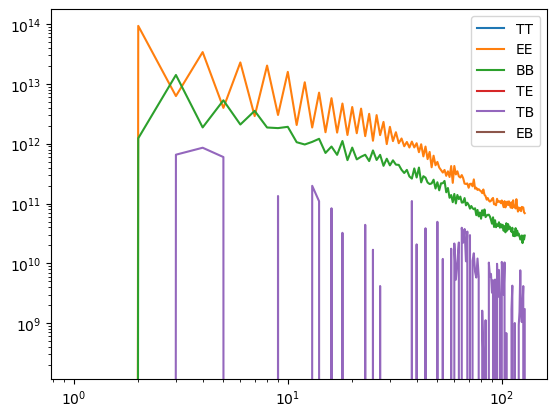

In [49]:
noise_weighted_input_freq_maps = np.einsum('fg,gsp->fsp', MICMAC_obj.freq_inverse_noise/hp.nside2resol(MICMAC_obj.nside)**2, input_freq_maps)

n_freq = 3
noise_weighted_input_freq_maps_extended = np.vstack((np.zeros_like(noise_weighted_input_freq_maps[0,0]), noise_weighted_input_freq_maps[n_freq]))
noise_weighted_spectra_input_freq_pix = hp.anafast(noise_weighted_input_freq_maps_extended, lmax=MICMAC_obj.lmax, iter=MICMAC_obj.n_iter)*(2*np.arange(MICMAC_obj.lmax+1)+1)

plt.plot(noise_weighted_spectra_input_freq_pix.T)
plt.loglog()
plt.legend(['TT', 'EE', 'BB', 'TE', 'TB', 'EB'])
plt.show()

In [50]:
# def alms_x_red_covariance_cell_JAX_new(
#     alm_Stokes_input, red_matrix, lmin, n_iter=8
# ):
#     """Return maps convolved with the covariance matrix given as input, assuming it's block diagonal

#     The input matrix have to start from ell=lmin, otherwise the lmax associated with the harmonic
#     operations will be wrong

#     Parameters
#     ----------
#     :param alms_Stokes_input: input alms of shape (nstokes, (lmax + 1) * (lmax // 2 + 1)))
#     :param red_matrix: input reduced spectra of shape (lmax+1-lmin, nstokes, nstokes)
#     :param lmin: minimum ell for the spectrum, int
#     :param n_iter: number of iterations for harmonic operations, int

#     Returns
#     -------
#     :return: maps_output: output maps of shape (nstokes, n_pix)
#     """

#     # all_params = 3

#     # Getting scalar parameters from the input covariance
#     lmax = red_matrix.shape[0] - 1 + lmin
#     nstokes = red_matrix.shape[1]

#     # Wrapper for almxfl, to prepare the pure callback of JAX
#     def wrapper_almxfl(alm_, matrix_ell):
#         return hp.almxfl(alm_, matrix_ell, inplace=False)

#     def pure_call_almxfl(alm_, matrix_ell):
#         shape_output = [(lmax + 1) * (lmax // 2 + 1)]
#         return jax.pure_callback(
#             wrapper_almxfl,
#             jax.ShapeDtypeStruct(shape_output, np.complex128),
#             alm_,
#             matrix_ell,
#         )
#     # Building the full covariance matrix from the covariance matrix
#     red_decomp = jnp.zeros((lmax + 1, nstokes, nstokes))
#     # if nstokes != 1:
#     #     red_decomp = red_decomp.at[lmin:, 3 - nstokes :, 3 - nstokes :].set(
#     #         red_matrix
#     #     )
#     #     if alm_Stokes_input.shape[0] != nstokes:
#     #         alm_input = jnp.vstack((jnp.zeros_like(alm_Stokes_input[0]), alm_Stokes_input))
#     #     else:
#     #         alm_input = jnp.copy(alm_Stokes_input)
#     # else:
#     alm_input = jnp.copy(alm_Stokes_input)
#     red_decomp = red_decomp.at[lmin:].set(red_matrix)

#     # Multiplying the alms with the covariance matrix for each stokes parameter contribution
#     def scan_func(carry, nstokes_j):
#         val_alms_j, nstokes_i = carry
#         # result_callback = pure_call_almxfl(
#         #     alm_input[nstokes_j], red_decomp[:, nstokes_i, nstokes_j]
#         # )
#         result_callback = JAX_almxfl(
#             alm_input[nstokes_j], red_decomp[:, nstokes_i, nstokes_j], lmax
#         )
#         new_carry = (val_alms_j + result_callback, nstokes_i)
#         return new_carry, val_alms_j + result_callback

#     # Multiplying the ie alms with the covariance matrix
#     def fmap(nstokes_i):
#         return jlax.scan(
#             scan_func,
#             (jnp.zeros_like(alm_input[0]), nstokes_i),
#             jnp.arange(nstokes),
#         )[0][0]

#     # Multiplying the alms with the covariance matrix
#     alms_output = jax.vmap(fmap, in_axes=0)(jnp.arange(nstokes))

#     # if nstokes != 1:
#     #     return alms_output[
#     #         3 - nstokes :, ...
#     #     ]  # If only polarization maps are given, return only polarization alms
#     return alms_output


In [51]:
n_freq = 3

noise_weighted_input_freq_maps = np.einsum('fg,gsp->fsp', MICMAC_obj.freq_inverse_noise/hp.nside2resol(MICMAC_obj.nside)**2, input_freq_maps)
noise_weighted_input_freq_maps_extended = np.vstack((np.zeros_like(noise_weighted_input_freq_maps[0,0]), noise_weighted_input_freq_maps[n_freq]))
noise_weighted_spectra_input_freq_pix = hp.anafast(noise_weighted_input_freq_maps_extended, lmax=MICMAC_obj.lmax, iter=MICMAC_obj.n_iter)*(2*np.arange(MICMAC_obj.lmax+1)+1)

red_specific_freq_noise = jnp.einsum('l,sk->lsk', MICMAC_obj.freq_noise_c_ell[n_freq,n_freq], jnp.eye(MICMAC_obj.nstokes))
red_specific_freq_noise_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix_jax(red_specific_freq_noise)
# red_specific_freq_noise = jnp.einsum('l,sk->lsk', np.ones(MICMAC_obj.lmax+1-MICMAC_obj.lmin), jnp.eye(MICMAC_obj.nstokes))

noise_weighted_alm_data_f = micmac.alms_x_red_covariance_cell_JAX(freq_alms_input[n_freq], red_specific_freq_noise, lmin=MICMAC_obj.lmin, n_iter=MICMAC_obj.n_iter)
alm_data_special_freq = freq_alms_input[n_freq]

noise_weighted_alm_data_f_extended = np.vstack((np.zeros_like(noise_weighted_alm_data_f[0]), noise_weighted_alm_data_f))
cl_noise_weighted = hp.alm2cl(np.array(noise_weighted_alm_data_f_extended), lmax=MICMAC_obj.lmax)*(2*np.arange(MICMAC_obj.lmax+1)+1)

plt.plot(cl_noise_weighted[np.array([1,2,4])].T)
plt.plot(noise_weighted_spectra_input_freq_pix[np.array([1,2,4])].T, '-.')
plt.loglog()
plt.show()

In [52]:
freq_red_inverse_noise[4,:,0,0,0]

Array([     0.        ,      0.        ,      0.        ,      0.        ,
       149199.63211769,      0.        ], dtype=float64)

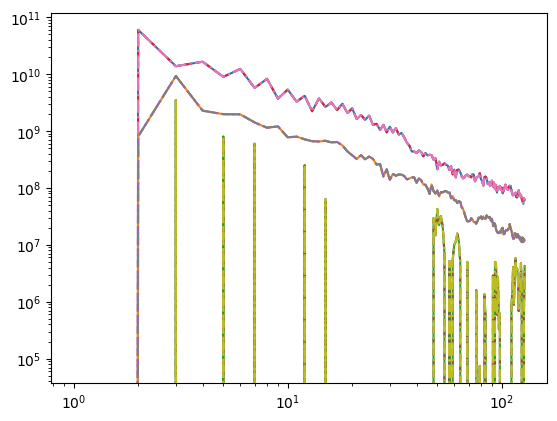

In [53]:
n_freq = 1

noise_weighted_input_freq_maps = np.einsum('fg,gsp->fsp', MICMAC_obj.freq_inverse_noise/hp.nside2resol(MICMAC_obj.nside)**2, input_freq_maps)
noise_weighted_input_freq_maps_extended = np.vstack((np.zeros_like(noise_weighted_input_freq_maps[0,0]), noise_weighted_input_freq_maps[n_freq]))
noise_weighted_spectra_input_freq_pix = hp.anafast(noise_weighted_input_freq_maps_extended, lmax=MICMAC_obj.lmax, iter=MICMAC_obj.n_iter)*(2*np.arange(MICMAC_obj.lmax+1)+1)



freq_red_inverse_noise = jnp.einsum('fgl,sk->fglsk', MICMAC_obj.freq_noise_c_ell, jnp.eye(MICMAC_obj.nstokes))

# noise_weighted_alm_data_f = micmac.alms_x_red_covariance_cell_JAX(freq_alms_input[n_freq], red_specific_freq_noise, lmin=MICMAC_obj.lmin, n_iter=MICMAC_obj.n_iter)
# noise_weighted_alm_data_2 = micmac.frequency_alms_x_obj_red_covariance_cell_JAX(freq_alms_input, freq_red_inverse_noise, lmin=MICMAC_obj.lmin, n_iter=MICMAC_obj.n_iter)

copy_freq_alms_input = np.zeros_like(freq_alms_input)
copy_freq_alms_input[n_freq] = freq_alms_input[n_freq]
copy_freq_red_inverse_noise = jnp.zeros_like(freq_red_inverse_noise)
copy_freq_red_inverse_noise = copy_freq_red_inverse_noise.at[n_freq, n_freq].set(freq_red_inverse_noise[n_freq, n_freq])

# noise_weighted_alm_data_2 = micmac.frequency_alms_x_obj_red_covariance_cell_JAX(copy_freq_alms_input, freq_red_inverse_noise, lmin=MICMAC_obj.lmin, n_iter=MICMAC_obj.n_iter)
noise_weighted_alm_data_2 = micmac.frequency_alms_x_obj_red_covariance_cell_JAX(copy_freq_alms_input, copy_freq_red_inverse_noise, lmin=MICMAC_obj.lmin, n_iter=MICMAC_obj.n_iter)

noise_weighted_alm_data_2b = micmac.alms_x_red_covariance_cell_JAX(copy_freq_alms_input[n_freq], copy_freq_red_inverse_noise[n_freq,n_freq], MICMAC_obj.lmin, n_iter=MICMAC_obj.n_iter)

noise_weighted_alm_data_2_extended = np.vstack((np.zeros_like(noise_weighted_alm_data_2[0,0]), noise_weighted_alm_data_2[n_freq]))
cl_noise_weighted = hp.alm2cl(np.array(noise_weighted_alm_data_2_extended), lmax=MICMAC_obj.lmax)*(2*np.arange(MICMAC_obj.lmax+1)+1)

noise_weighted_alm_data_2b_extended = np.vstack((np.zeros_like(noise_weighted_alm_data_2b[0]), noise_weighted_alm_data_2b))
cl_noise_weighted_b = hp.alm2cl(np.array(noise_weighted_alm_data_2b_extended), lmax=MICMAC_obj.lmax)*(2*np.arange(MICMAC_obj.lmax+1)+1)

plt.plot(cl_noise_weighted[np.array([1,2,4])].T)
plt.plot(cl_noise_weighted_b[np.array([1,2,4])].T, '--')
plt.plot(noise_weighted_spectra_input_freq_pix[np.array([1,2,4])].T, '-.')
plt.loglog()
plt.show()

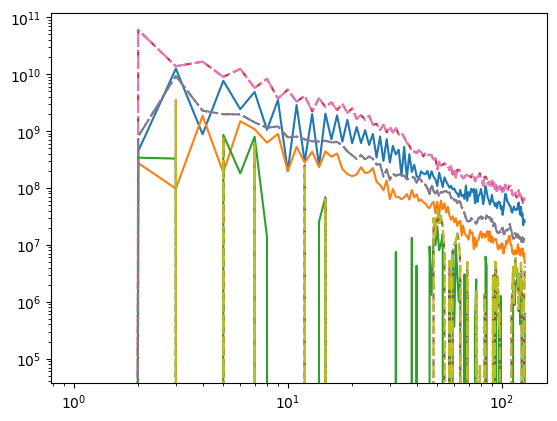

In [54]:
n_freq = 1
freq_red_inverse_noise = jnp.einsum('fgl,sk->fglsk', MICMAC_obj.freq_noise_c_ell, jnp.eye(MICMAC_obj.nstokes))

# noise_weighted_alm_data_f = micmac.alms_x_red_covariance_cell_JAX(freq_alms_input[n_freq], red_specific_freq_noise, lmin=MICMAC_obj.lmin, n_iter=MICMAC_obj.n_iter)
# noise_weighted_alm_data_2 = micmac.frequency_alms_x_obj_red_covariance_cell_JAX(freq_alms_input, freq_red_inverse_noise, lmin=MICMAC_obj.lmin, n_iter=MICMAC_obj.n_iter)

copy_freq_alms_input = np.zeros_like(freq_alms_input)
copy_freq_alms_input[n_freq] = freq_alms_input[n_freq]
copy_freq_red_inverse_noise = jnp.zeros_like(freq_red_inverse_noise)
copy_freq_red_inverse_noise = copy_freq_red_inverse_noise.at[n_freq, n_freq].set(freq_red_inverse_noise[n_freq, n_freq])

noise_weighted_input_freq_maps = np.einsum('fg,gsp->fsp', MICMAC_obj.freq_inverse_noise/hp.nside2resol(MICMAC_obj.nside)**2, input_freq_maps)
noise_weighted_input_freq_maps_extended = np.vstack((np.zeros_like(noise_weighted_input_freq_maps[0,0]), noise_weighted_input_freq_maps[n_freq]))
noise_weighted_spectra_input_freq_pix = hp.anafast(noise_weighted_input_freq_maps_extended, lmax=MICMAC_obj.lmax, iter=MICMAC_obj.n_iter)*(2*np.arange(MICMAC_obj.lmax+1)+1)

freq_alm_input = jnp.copy(copy_freq_alms_input)
freq_red_matrix = jnp.copy(copy_freq_red_inverse_noise)

def scan_func(carry, frequency_j):
    val_alms_j, idx_i = carry
    result_callback = alms_x_red_covariance_cell_JAX(
        freq_alm_input[frequency_j], freq_red_matrix[idx_i, frequency_j, ...], MICMAC_obj.lmax)
    new_carry = (val_alms_j + result_callback, idx_i)
    return new_carry, val_alms_j + result_callback

# Multiplying the ie alms with the covariance matrix
def fmap(idx_i):
    return jlax.scan(
        scan_func,
        (jnp.zeros_like(freq_alm_input[0]), idx_i),
        jnp.arange(MICMAC_obj.n_frequencies),
    )[0][0]

# Multiplying the alms with the covariance matrix
noise_weighted_alm_data_2c = jax.vmap(fmap, in_axes=0)(jnp.arange(MICMAC_obj.n_frequencies))
    

# noise_weighted_alm_data_2 = micmac.frequency_alms_x_obj_red_covariance_cell_JAX(copy_freq_alms_input, freq_red_inverse_noise, lmin=MICMAC_obj.lmin, n_iter=MICMAC_obj.n_iter)
noise_weighted_alm_data_2 = micmac.frequency_alms_x_obj_red_covariance_cell_JAX(copy_freq_alms_input, copy_freq_red_inverse_noise, lmin=MICMAC_obj.lmin, n_iter=MICMAC_obj.n_iter)

noise_weighted_alm_data_2b = micmac.alms_x_red_covariance_cell_JAX(copy_freq_alms_input[n_freq], copy_freq_red_inverse_noise[n_freq,n_freq], MICMAC_obj.lmin, n_iter=MICMAC_obj.n_iter)

noise_weighted_alm_data_2_extended = np.vstack((np.zeros_like(noise_weighted_alm_data_2[0,0]), noise_weighted_alm_data_2[n_freq]))
cl_noise_weighted = hp.alm2cl(np.array(noise_weighted_alm_data_2_extended), lmax=MICMAC_obj.lmax)*(2*np.arange(MICMAC_obj.lmax+1)+1)

noise_weighted_alm_data_2c_extended = np.vstack((np.zeros_like(noise_weighted_alm_data_2c[0,0]), noise_weighted_alm_data_2c[n_freq]))
cl_noise_weighted = hp.alm2cl(np.array(noise_weighted_alm_data_2c_extended), lmax=MICMAC_obj.lmax)*(2*np.arange(MICMAC_obj.lmax+1)+1)

noise_weighted_alm_data_2b_extended = np.vstack((np.zeros_like(noise_weighted_alm_data_2b[0]), noise_weighted_alm_data_2b))
cl_noise_weighted_b = hp.alm2cl(np.array(noise_weighted_alm_data_2b_extended), lmax=MICMAC_obj.lmax)*(2*np.arange(MICMAC_obj.lmax+1)+1)

plt.plot(cl_noise_weighted[np.array([1,2,4])].T)
plt.plot(cl_noise_weighted_b[np.array([1,2,4])].T, '--')
plt.plot(noise_weighted_spectra_input_freq_pix[np.array([1,2,4])].T, '-.')
plt.loglog()
plt.show()

In [55]:
copy_freq_alms_input_2 = jnp.zeros_like(copy_freq_alms_input)
copy_freq_alms_input_2 = copy_freq_alms_input_2.at[n_freq, 0].set(1)

micmac.alms_x_red_covariance_cell_JAX(
                        copy_freq_alms_input_2[n_freq], 
                        copy_freq_red_inverse_noise[n_freq,n_freq], 
                        MICMAC_obj.lmin, n_iter=MICMAC_obj.n_iter).mean()

Array(6696.52448077+0.j, dtype=complex128)

In [56]:
def scan_func_2(carry, frequency_j):
    print("Freq test", frequency_j, flush=True)
    val_alms_j, idx_i = carry
    result_callback = alms_x_red_covariance_cell_JAX(
        copy_freq_alms_input_2[frequency_j], copy_freq_red_inverse_noise[n_freq, frequency_j, ...], MICMAC_obj.lmin, n_iter=MICMAC_obj.n_iter)
    print("Test 2, result_callback", result_callback.mean(), "freq", frequency_j, flush=True)
    new_carry = (val_alms_j + result_callback, idx_i)
    return new_carry, val_alms_j + result_callback


def my_scan(f, init, xs, length=None):
    if xs is None:
        xs = [None] * length
    carry = init
    ys = []
    for x in xs:
        carry, y = f(carry, x)
        ys.append(y)
    return carry, np.stack(ys)

jlax.scan(
        scan_func_2,
        (jnp.zeros_like(freq_alm_input[0]), n_freq),
        jnp.arange(MICMAC_obj.n_frequencies),
    )[0][0].mean()

Freq test Traced<ShapedArray(int64[])>with<DynamicJaxprTrace(level=1/0)>


Test 2, result_callback Traced<ShapedArray(complex128[])>with<DynamicJaxprTrace(level=1/0)> freq Traced<ShapedArray(int64[])>with<DynamicJaxprTrace(level=1/0)>


Array(6696.52448077+0.j, dtype=complex128)

In [57]:
n_freq

1

In [58]:
my_scan(scan_func_2, (jnp.zeros_like(freq_alm_input[0]), n_freq), jnp.arange(MICMAC_obj.n_frequencies))[0][0].mean()

Freq test 0


Test 2, result_callback 0j freq 0
Freq test 1
Test 2, result_callback (6696.524480768585+0j) freq 1
Freq test 2
Test 2, result_callback 0j freq 2
Freq test 3
Test 2, result_callback 0j freq 3
Freq test 4
Test 2, result_callback 0j freq 4
Freq test 5
Test 2, result_callback 0j freq 5


Array(6696.52448077+0.j, dtype=complex128)

In [59]:
inv_BtinvNB_c_ell = micmac.get_inv_BtinvNB_c_ell(MICMAC_obj.freq_noise_c_ell, mixing_matrix_sampled)
freq_red_inverse_noise = jnp.einsum('fgl,sk->fglsk', MICMAC_obj.freq_noise_c_ell, jnp.eye(MICMAC_obj.nstokes))
noise_weighted_alm_data = frequency_alms_x_obj_red_covariance_cell_JAX(freq_alms_input, freq_red_inverse_noise, lmin=MICMAC_obj.lmin, n_iter=MICMAC_obj.n_iter)


multiplicative_term_s_cML_ = jnp.einsum('ckl,fk->cfl',
                            inv_BtinvNB_c_ell,
                            mixing_matrix_sampled)
multiplicative_term_s_cML = jnp.einsum('cfl,sk->cflsk', multiplicative_term_s_cML_, jnp.eye(MICMAC_obj.nstokes))
s_cML = micmac.frequency_alms_x_obj_red_covariance_cell_JAX(noise_weighted_alm_data, multiplicative_term_s_cML, lmin=MICMAC_obj.lmin, n_iter=MICMAC_obj.n_iter)[0,...]

s_cML_extended = np.vstack((np.zeros_like(s_cML[0]), s_cML))
spectra_s_cML = hp.alm2cl(s_cML_extended, lmax=MICMAC_obj.lmax)*(2*jnp.arange(MICMAC_obj.lmax+1)+1)

In [60]:
multiplicative_term_s_cML.shape

(3, 6, 127, 2, 2)

In [61]:
MICMAC_obj.freq_inverse_noise = get_noise_covar(instrument['depth_p'], MICMAC_obj.nside)
s_cML_pix = micmac.get_Wd(MICMAC_obj.freq_inverse_noise/(hp.nside2resol(MICMAC_obj.nside)**2), mixing_matrix_sampled, input_freq_maps, jax_use=True)[0]
spectra_s_cML_pix = micmac.get_cell_from_map_jax(s_cML_pix, lmax=MICMAC_obj.lmax, n_iter=MICMAC_obj.n_iter)*(2*jnp.arange(MICMAC_obj.lmax+1)+1)

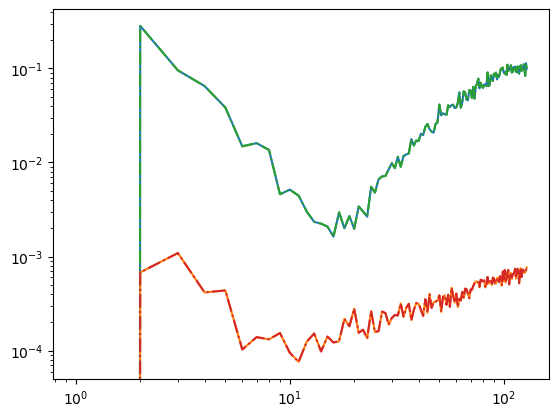

In [62]:
plt.plot(spectra_s_cML[indices_polar].T)
plt.plot(spectra_s_cML_pix[np.array([0,1])].T, '-.')
plt.loglog()
plt.show()


## Computing contributions

In [63]:
red_CMB_cell = theoretical_red_cov_r0_total + MICMAC_obj.r_true*theoretical_red_cov_r1_tensor

inv_BtinvNB_c_ell = micmac.get_inv_BtinvNB_c_ell(MICMAC_obj.freq_noise_c_ell, mixing_matrix_sampled)
effective_noise_CMB_c_ell = inv_BtinvNB_c_ell[0,0]
red_noise_CMB = jnp.einsum('l,sk->lsk', effective_noise_CMB_c_ell, jnp.eye(MICMAC_obj.nstokes))


central_term_2 = jnp.linalg.pinv(red_noise_CMB + red_CMB_cell)
alm_central_term_2 = alms_x_red_covariance_cell_JAX(s_cML, central_term_2, lmin=MICMAC_obj.lmin, n_iter=MICMAC_obj.n_iter)
        

In [84]:
sigma_ell_s_cML_pix = (micmac.get_reduced_matrix_from_c_ell_jax(spectra_s_cML_pix))[MICMAC_obj.lmin:]

contribution_pix_equivalent = jnp.einsum('lij,lji->l', sigma_ell_s_cML_pix, central_term_2).sum()

In [85]:
alm_central_term_2 = alms_x_red_covariance_cell_JAX(s_cML, central_term_2, lmin=MICMAC_obj.lmin, n_iter=MICMAC_obj.n_iter)
contribution_alm_harm = alm_dot_product_JAX(s_cML, alm_central_term_2, MICMAC_obj.lmax)

In [86]:
contribution_pix_equivalent, contribution_alm_harm

(Array(32963.82700067, dtype=float64), Array(32963.82700067, dtype=float64))

In [75]:
spectra_s_cML_pix[:MICMAC_obj.nstokes].sum()

Array(6.93153863, dtype=float64)

In [76]:
alm_dot_product_JAX(s_cML,s_cML, MICMAC_obj.lmax)

Array(6.93153863, dtype=float64)